# Setup

In [16]:
from pathlib import Path

import kuzu
import pandas as pd

import graph.visualization as vis
from shared.settings import LOCAL_DIR, env

In [17]:
db_path = Path(LOCAL_DIR) / env.str("ECON_COMP_GRAPH_DB")
assert db_path.exists(), "You need to create the graph DB using dlctl first"

In [18]:
db = kuzu.Database(db_path)
conn = kuzu.Connection(db)

In [19]:
LABEL_PROPS = {
    "Country": "country_name_short",
    "Product": "product_name_short",
}

# Analysis

## Top 10 Dominating Economies

In [25]:
dom_econ_df = conn.execute(
    """
    MATCH (c:Country)
    RETURN c, c.node_id AS node_id, c.country_name_short AS country
    ORDER BY c.con_score DESC
    LIMIT 10
    """
).get_as_df()[["node_id", "country"]]

dom_econ_df.index = pd.RangeIndex(start=1, stop=len(dom_econ_df) + 1, name="rank")
dom_econ_df

,node_id,country
rank,,
1,206,United States of America
2,55,Canada
3,34,United Arab Emirates
4,107,Netherlands
5,132,United Kingdom
6,175,Belgium
7,134,Italy
8,223,Spain
9,131,France


### Top 3 Exports

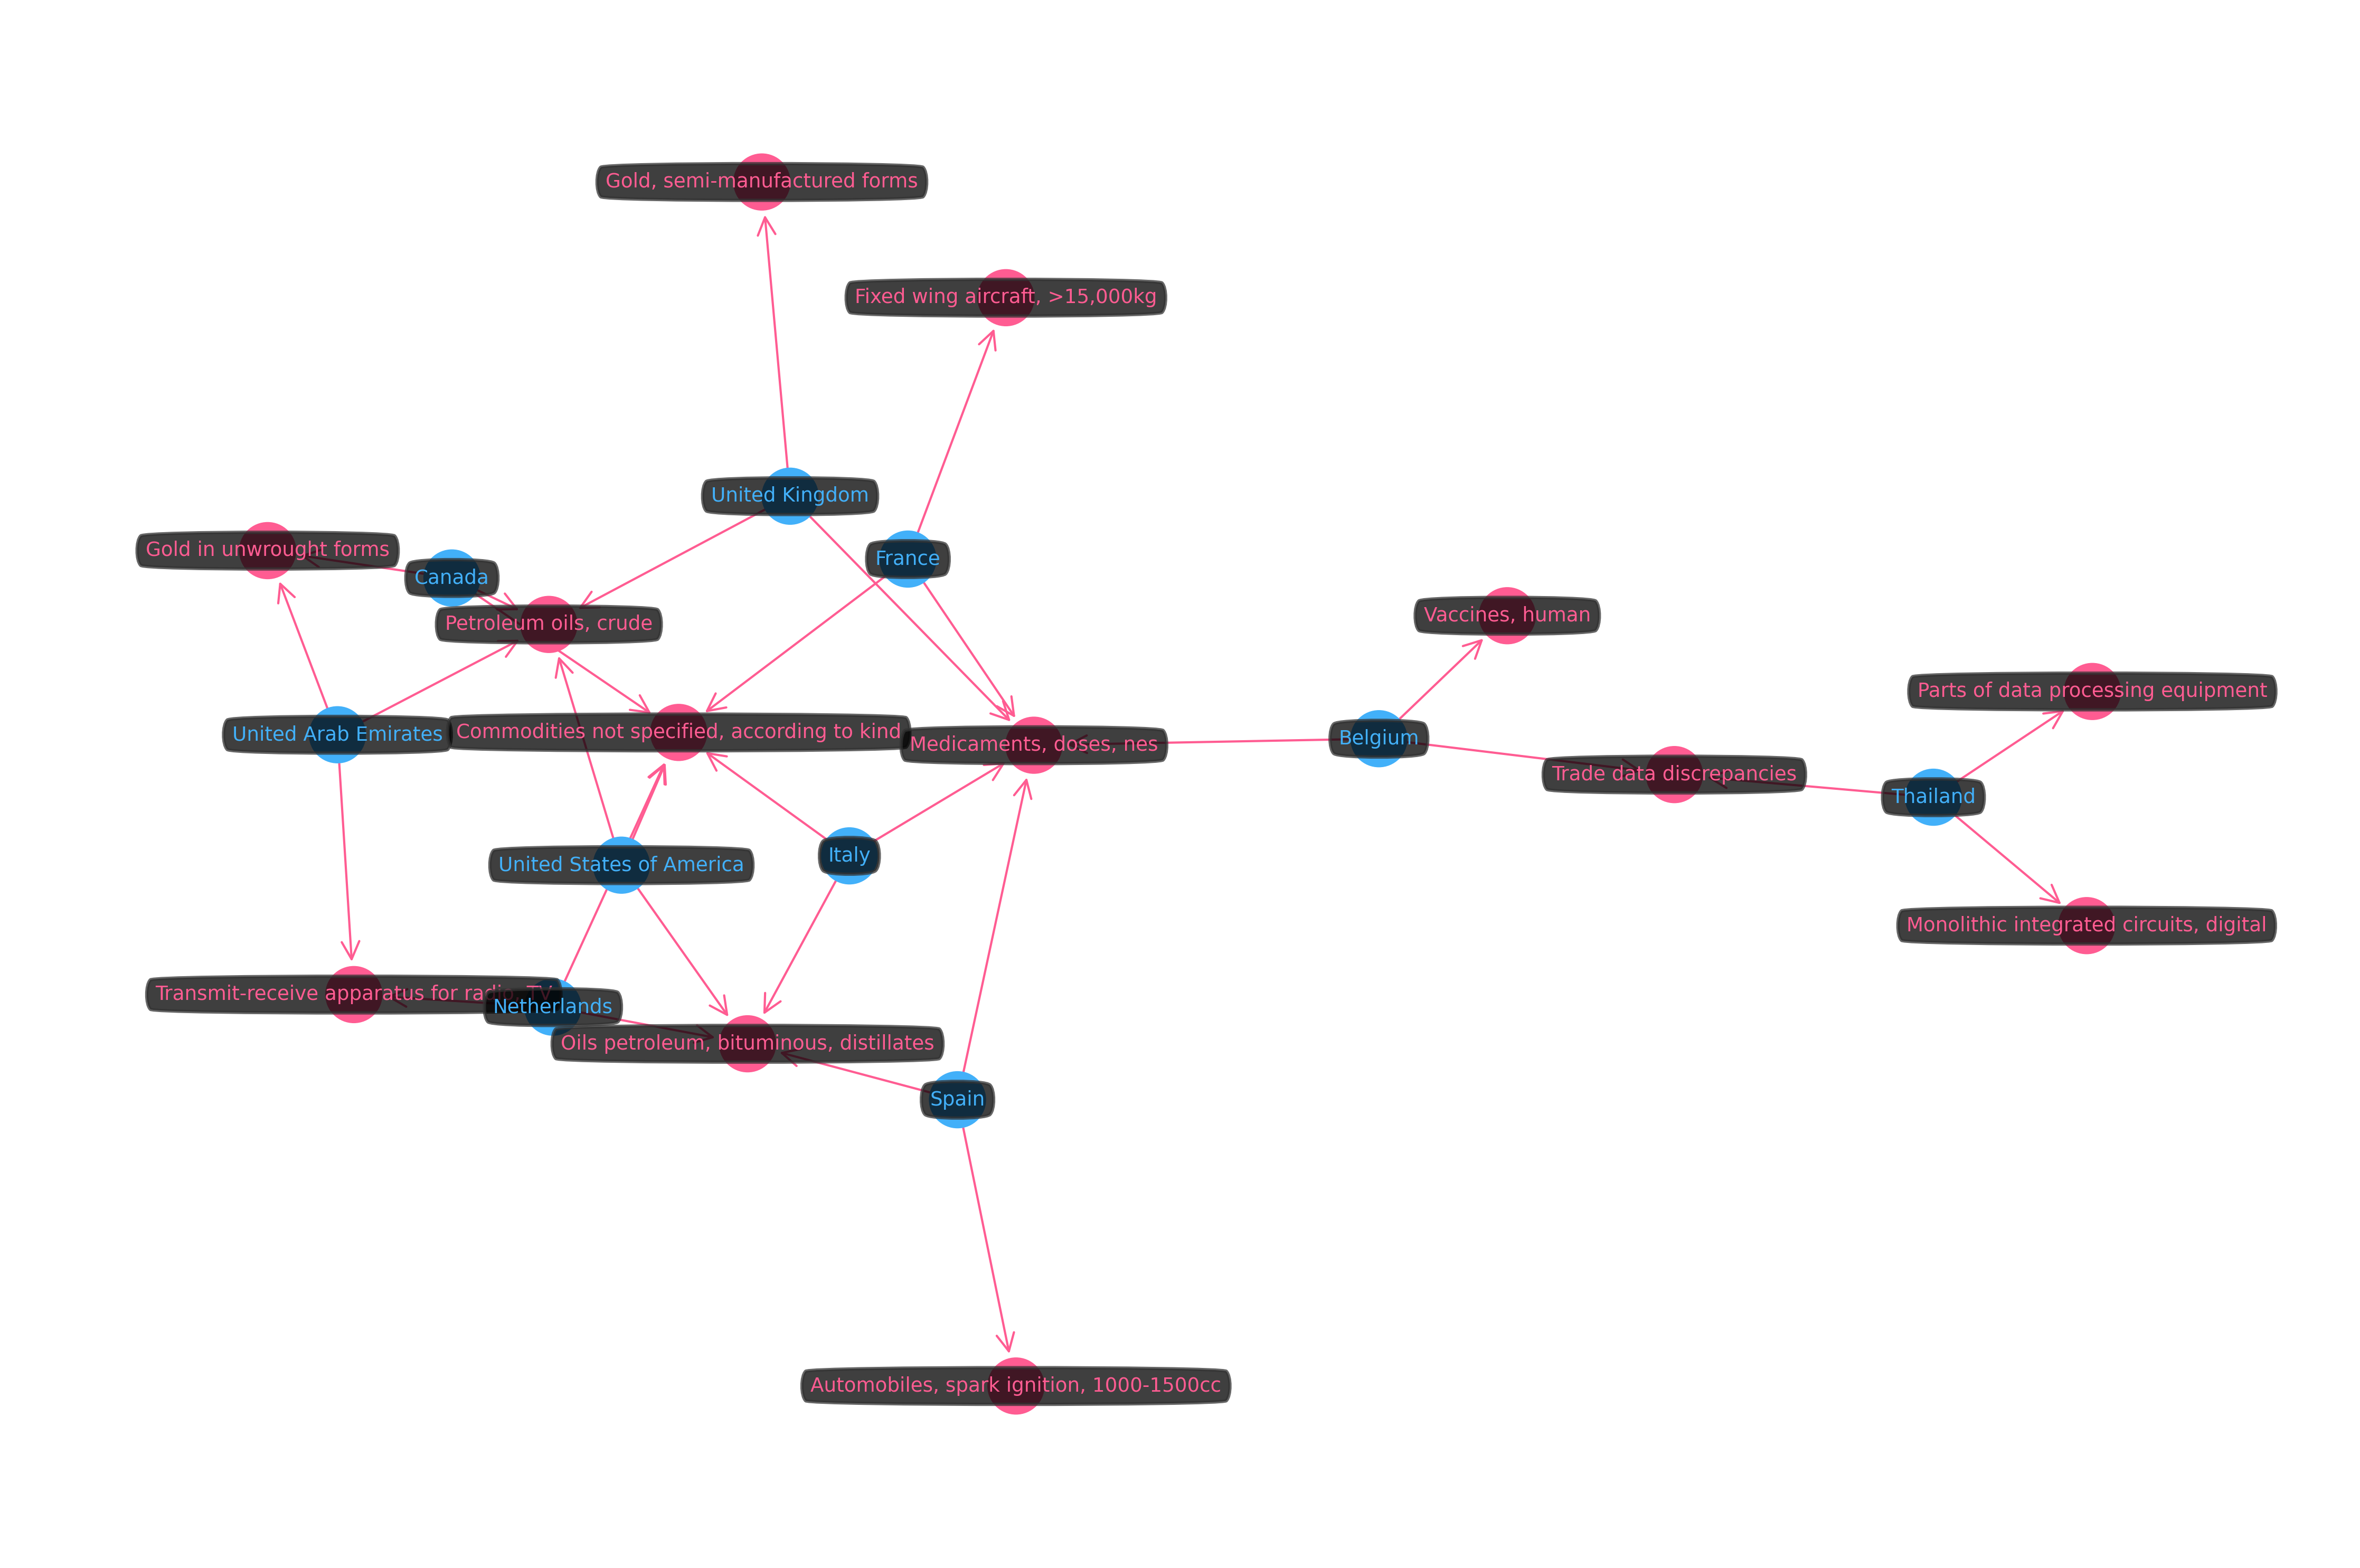

In [21]:
dom_econ_g = conn.execute(
    """
    MATCH (c:Country)
    WITH c
    ORDER BY c.con_score DESC
    LIMIT 10

    MATCH (c)-[e:Exports]->(p:Product)
    MATCH (c2:Country)-[:Exports]->(p)

    WITH c, e, p, count(DISTINCT c2) AS exporters
    WHERE exporters > 1
    WITH c, e, p
    ORDER BY c.node_id, e.amount_usd DESC
    SKIP 0

    WITH c, collect({p: p, e: e}) AS export_list

    UNWIND list_slice(export_list, 0, 3) AS r
    RETURN c, r.e, r.p
    ORDER BY c.node_id, r.p.node_id
    """
).get_as_networkx()

vis.set_labels(dom_econ_g, LABEL_PROPS)
vis.plot(dom_econ_g, scale=1.25, seed=3)

## Bottom 10 Weaker Economies

In [26]:
weak_econ_df = conn.execute(
    """
    MATCH (c:Country)
    RETURN c, c.node_id AS node_id, c.country_name_short AS country
    ORDER BY c.con_score ASC
    LIMIT 10
    """
).get_as_df()[["node_id", "country"]]

weak_econ_df.index = pd.RangeIndex(start=1, stop=len(weak_econ_df) + 1, name="rank")
weak_econ_df

,node_id,country
rank,,
1,193,Undeclared
2,72,Bouvet Island
3,170,Wallis and Futuna
4,106,Norfolk Island
5,167,Saint Pierre and Miquelon
6,216,Niue
7,66,South Georgia and South Sandwich Islds.
8,121,Northern Mariana Islands
9,161,Heard and McDonald Islands


### Top 3 Exports

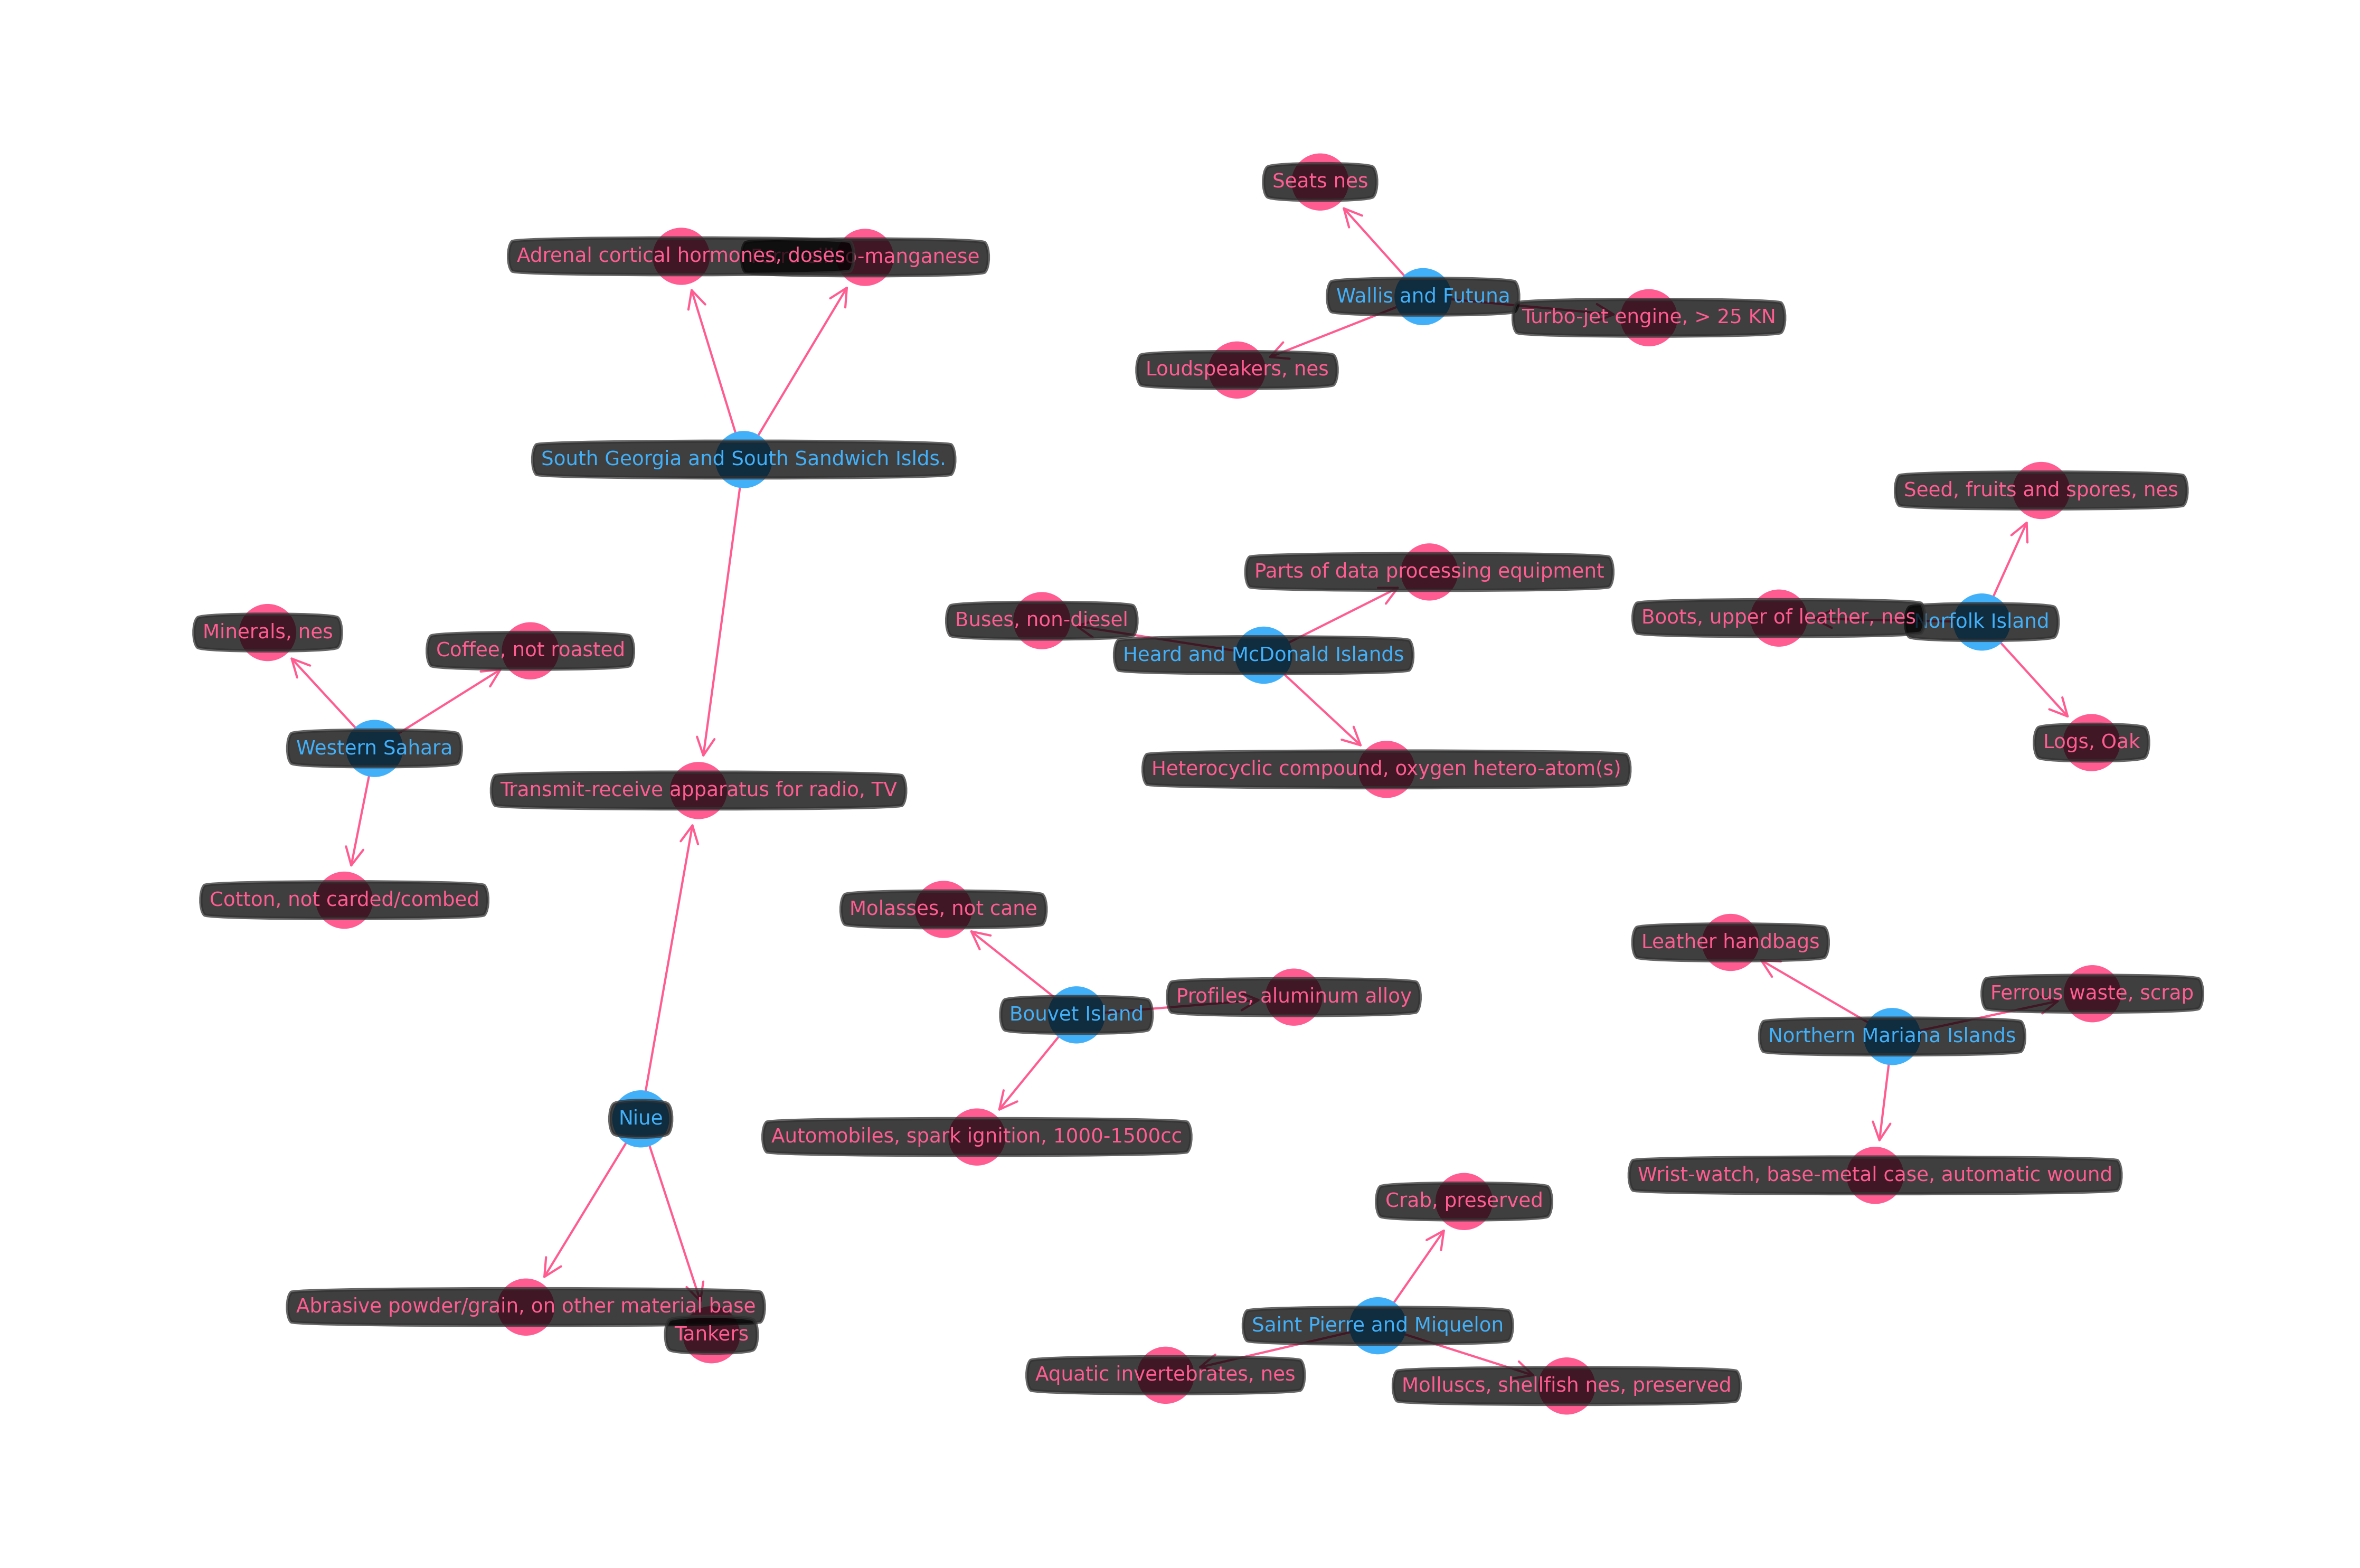

In [23]:
weak_econ_g = conn.execute(
    """
    MATCH (c:Country)
    WITH c
    ORDER BY c.con_score ASC
    LIMIT 10

    MATCH (c)-[e:Exports]->(p:Product)
    MATCH (c2:Country)-[:Exports]->(p)

    WITH c, e, p, count(DISTINCT c2) AS exporters
    WHERE exporters > 1
    WITH c, e, p
    ORDER BY c.node_id, e.amount_usd DESC
    SKIP 0

    WITH c, collect({p: p, e: e}) AS export_list

    UNWIND list_slice(export_list, 0, 3) AS r
    RETURN c, r.e, r.p
    ORDER BY c.node_id, r.p.node_id
    """
).get_as_networkx()

vis.set_labels(weak_econ_g, LABEL_PROPS)
vis.plot(weak_econ_g, scale=1.25, seed=3)

## Dominating vs Weaker Economies

In [ ]:
# FIXME: use prepared statement with dominating and weaker node_ids
dom_vs_weak_econ_g = conn.execute(
    """
    MATCH (dom:Country)
    WITH dom
    ORDER BY dom.con_score DESC
    LIMIT 10

    WITH collect(dom) AS dom_countries

    MATCH (wea:Country)
    WITH wea, dom_countries
    ORDER BY wea.con_score ASC
    LIMIT 10

    UNWIND dom_countries AS dom
    WITH dom, wea, dom_countries
    MATCH (wea)-[e:Exports]->(p:Product)
    MATCH (dom)-[:Exports]->(p)

    WITH wea, e, p, count(DISTINCT dom) AS dom_exporters, dom_countries
    WHERE dom_exporters > 0

    WITH wea, e, p, dom_countries
    ORDER BY wea.node_id, e.amount_usd DESC
    SKIP 0

    WITH wea, collect({p: p, e: e}) AS export_list, dom_countries
    UNWIND list_slice(export_list, 0, 1) AS r
    UNWIND dom_countries AS dom

    WITH wea, r.p.node_id AS prod_node_id, dom
    MATCH (wea)-[we:Exports]->(prod:Product { node_id: prod_node_id })
    MATCH (dom)-[de:Exports]->(prod)
    RETURN wea, we, prod, de, dom
    ORDER BY wea.node_id, prod.node_id, dom.node_id
    """
).get_as_networkx()

vis.set_labels(weak_econ_g, LABEL_PROPS)
vis.plot(weak_econ_g, scale=1.25, seed=3)

KeyError: (0, 134)

## Competition Clusters

In [ ]:
compnet_g = conn.execute(
    """
    MATCH (a:Country)-[cw:CompetesWith]->(b:Country)
    RETURN a, cw, b
    """
).get_as_networkx()

vis.set_labels(compnet_g, LABEL_PROPS)
vis.plot(compnet_g)

KeyboardInterrupt: 